# An Analysis of F1 Races and the Prediction of Outcomes
As someone who was recently introduced to the sport of Formula 1 I have quickly turned to love the sport and due to its very technical nature, it felt like the perfect opportunity to create visualizations and predictions.  In this Project I am to look at trends of the speeds of cars as well as see if there are certain factors within a race that can be used to predict final outcomes.

The data used has been located from https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020/code?select=results.csv

In [169]:
# import libraries
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
from bs4 import BeautifulSoup as soup
from urllib.request import urlopen as uReq
import pandas as pd
import unidecode
from scipy import stats
import math
import numpy as np
import pandas as pd
import qeds
import requests
import plotly as pt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode

from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
%matplotlib inline
# activate plot theme
qeds.themes.mpl_style();
colors = qeds.themes.COLOR_CYCLE

In [121]:
df_quali = pd.read_csv('qualifying.csv')
df_races = pd.read_csv('races.csv')
df_results = pd.read_csv('results.csv')
df_quali_races = pd.concat([df_quali, df_results], axis = 1)
df_quali_races = df_quali_races.loc[:,~df_quali_races.columns.duplicated()]

In [122]:
df_qr= df_quali_races.drop(["q1","q2","q3"], axis =1)


In [123]:
df_rr = pd.concat([df_races, df_results], axis = 1)
df_rr = df_rr.loc[:,~df_rr.columns.duplicated()]
df_rr = pd.merge(df_races, df_rr, on = 'name')

# Cleaning the Data

In [127]:
df_res_new = df_results.drop(['position', 'positionText','laps', 'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'statusId'], axis = 1)


In [128]:
# rename coloumns
df_res_new = df_res_new.rename(columns = {'resultId':'Result Id', 'raceId': 'Race Id', 'constructorId': 'Constructors Id', 'number' : 'Car Number',
                                  'positionOrder': 'Position', 'grid':'Qualifying Position', 'points': 'Points', 'time':'Time', 'miliiseconds':'Milliseconds',
                                          'driverId': 'Driver Id'})
df_res_new

In [171]:
order = df_rr.sort_values(by = 'year_x', ascending = True)
order = order.drop(['round_x', 'time_x','url_x','statusId','date_x', 'date_y', 'year_y',
                   'time_y', 'url_y', 'raceId_y', 'round_y', 'circuitId_y','position','positionText',], axis = 1)
order = order.rename(columns = {'raceId_x': 'Race Id', 'year_x':'Year','resultId': 'Results Id', 'driverId' : 'Driver Id',
                                  'constructorId': 'Constructor ID', 'grid':'Qualifying Position', 'points': 'Points',
                                'laps':'Laps', 'miliiseconds':'Milliseconds',
                                          'fastestLap': 'Fastest Lap', 'rank': 'Fastest Lap Position', 'number': 'Car Number'})
order = order.rename(columns = { 'circuitId_x': 'Circuit Id', 'name' : 'Name', 'positionOrder':'Position'})
order #i will leave this df alone for now and come back to use it again later

,Race Id,Year,Circuit Id,Name,Results Id,Driver Id,Constructor ID,Car Number,Qualifying Position,Position,Points,Laps,milliseconds,Fastest Lap,Fastest Lap Position,fastestLapTime,fastestLapSpeed
8811,834,1950,6,Monaco Grand Prix,941,30,6,5,1,1,10.0,73,5675199,56,1,1:12.719,207.527
29847,839,1950,14,Italian Grand Prix,171,22,11,17,16,3,6.0,60,6031713,21,11,1:33.386,198.183
29848,839,1950,14,Italian Grand Prix,187,20,5,15,8,19,0.0,0,\N,\N,\N,\N,\N
29849,839,1950,14,Italian Grand Prix,204,21,10,21,20,16,0.0,67,5564967,67,20,1:18.208,210.546
29850,839,1950,14,Italian Grand Prix,219,14,9,9,13,11,0.0,70,5917474,67,16,1:22.732,190.634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14962,1083,2022,9,British Grand Prix,833,13,6,6,3,3,6.0,60,5763212,19,5,1:33.099,199.065
14963,1083,2022,9,British Grand Prix,848,18,11,12,6,18,0.0,28,\N,9,13,1:34.042,197.069
14964,1083,2022,9,British Grand Prix,867,24,5,20,15,15,0.0,63,\N,52,14,1:18.488,212.226
14956,1083,2022,9,British Grand Prix,789,23,7,7,6,3,6.0,57,5692670,45,10,1:27.810,217.410


# Differences Between Qualifying and Final Position

In F1 there are two crucial days to every weekend, qualifying and race day. Who ever sets the fastest lap in qualifying will start at the front on the race day. In this section I will be showing the average positions lost/gained by the drivers on a race day given their qualifying performances

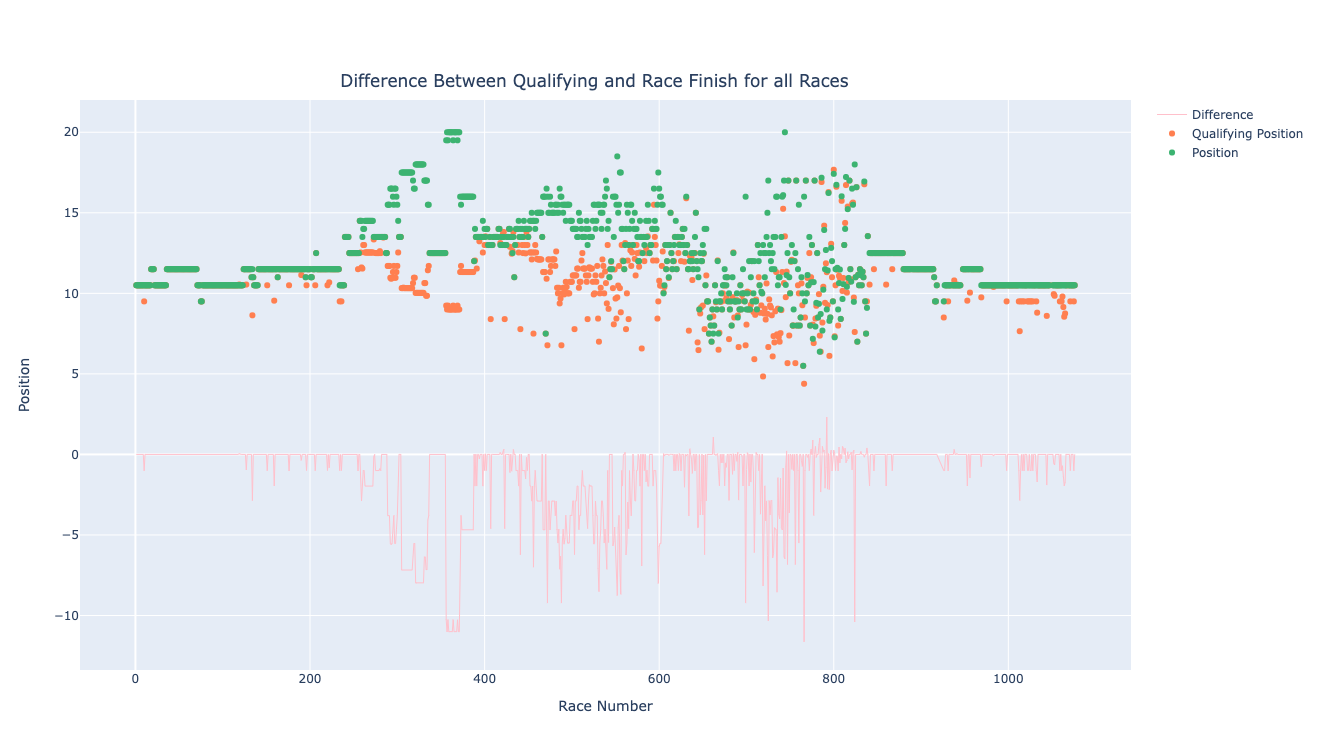

In [130]:
# now lets create some visualizations
# for each race we can get the average difference between positions gained/lost during the race relative to qualifying

# Generate yearly averages
by_race = df_res_new.groupby('Race Id').mean()
average_by_race = by_race.reset_index()
average_by_race['Difference'] = average_by_race['Qualifying Position'] - average_by_race['Position']

# Create plot
fig = go.Figure([
        go.Scatter(x = average_by_race['Race Id'], y = average_by_race['Difference'],line=dict(color='pink', width=1),mode='lines', name = "Difference"),
        go.Scatter(x = average_by_race['Race Id'], y = average_by_race['Qualifying Position'],line=dict(color='coral', width=0.1),mode='markers', name = "Qualifying Position"),
        go.Scatter(x = average_by_race['Race Id'], y = average_by_race['Position'],line=dict(color='mediumseagreen', width=0.1),mode='markers', name = "Position")])

fig.update_layout(
    height = 750,
    title={
        'text': "Difference Between Qualifying and Race Finish for all Races",
        'y':0.9,
        'x':0.45},
    xaxis_title="Race Number",
    yaxis_title="Position"
                                        
)
fig.show()


From the above graph we can see that on average racers finish is a position below their starting position. There is also a lot of instances where on average there is not a net gain or loss in position among the grid and that it is very rare for there to be a net gain. One way to explain this is that there is almost never a race in which drivers don't retire (their car crashes or breaks down making them unable to race) and in doing so you can lose 1-30 places which will of course cause the average to decrease by quite a significant amount

I now want to generate this same graph using only drivers who scored points - only those who finish in the top 10 of each race are awarded points for that race, the rest receive nothing.


In [133]:
earned_points = df_res_new.loc[df_res_new['Points']>0]

In [134]:
earned_points

,Result Id,Race Id,Driver Id,Constructors Id,Car Number,Qualifying Position,Position,Points,Time,milliseconds
0,1,18,1,1,22,1,1,10.0,1:34:50.616,5690616
1,2,18,2,2,3,5,2,8.0,+5.478,5696094
2,3,18,3,3,7,7,3,6.0,+8.163,5698779
3,4,18,4,4,5,11,4,5.0,+17.181,5707797
4,5,18,5,1,23,3,5,4.0,+18.014,5708630
...,...,...,...,...,...,...,...,...,...,...
25445,25451,1076,817,1,3,7,6,8.0,+53.737,5320285
25446,25452,1076,839,214,31,8,7,6.0,+1:01.683,5328231
25447,25453,1076,822,51,77,12,8,4.0,+1:08.439,5334987
25448,25454,1076,842,213,10,11,9,2.0,+1:16.221,5342769


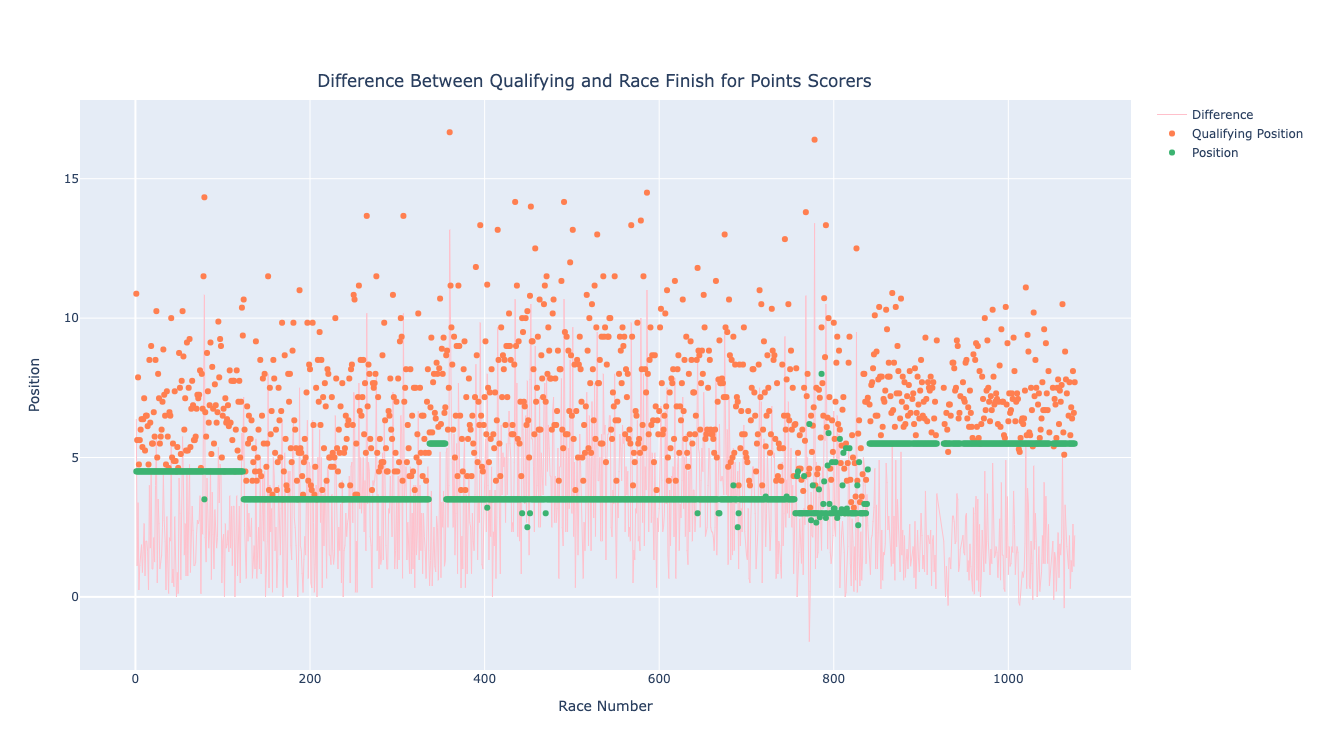

In [135]:
by_race_points = earned_points.groupby('Race Id').mean()
average_points = by_race_points.reset_index()
average_points['Difference'] = average_points['Qualifying Position'] - average_points['Position']

# Create plot
fig = go.Figure([
        go.Scatter(x = average_points['Race Id'], y = average_points['Difference'],line=dict(color='pink', width=1),mode='lines', name = "Difference"),
        go.Scatter(x = average_points['Race Id'], y = average_points['Qualifying Position'],line=dict(color='coral', width=0.1),mode='markers', name = "Qualifying Position"),
        go.Scatter(x = average_points['Race Id'], y = average_points['Position'],line=dict(color='mediumseagreen', width=0.1),mode='markers', name = "Position")])

fig.update_layout(
    height = 750,
    title={
        'text': "Difference Between Qualifying and Race Finish for Points Scorers",
        'y':0.9,
        'x':0.45},
    xaxis_title="Race Number",
    yaxis_title="Position"
                                        
)
fig.show()

The trend now is the complete opposite and by a much larger magnitude, racers on average are qualifying in worse positions and are on average finishing in much positions, now that we have taken only points scorers we see that there is hardly an average loss of position and hardly an average net zero gain/loss of position.

# Simple Linear Regressions

Simple linear model: Position = 11.1085 + 0.1610 Qualifying Position


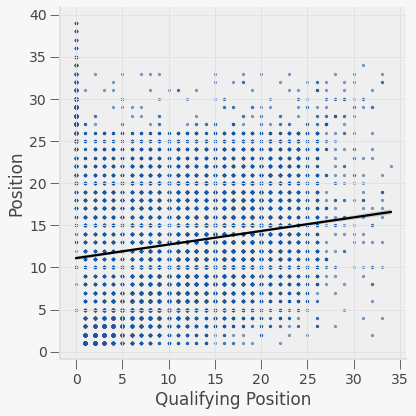

In [138]:
from sklearn import linear_model


x = df_res_new.copy()
y = df_res_new['Position']

simple_lr_reg = linear_model.LinearRegression()

simple_lr_reg.fit(x[["Qualifying Position"]], y)

beta_0 = simple_lr_reg.intercept_
beta_1 = simple_lr_reg.coef_[0]

print(f"Simple linear model: Position = {beta_0:.4f} + {beta_1:.4f} Qualifying Position")

sns.lmplot(
    data=df_res_new, x="Qualifying Position", y="Position", height=6,
    scatter_kws=dict(s=5, alpha=0.5),
    line_kws={'color': 'black'}
);

After running this regression I can clearly see that it is not a good estimator for results. With this regression it predicts that someone who qualifies in first will finish in 12th place (after rounding). There is clearly a lot of bias in this regression. A few things that come to mind first are: Firstly, those who retire from a race skew the results. Secondly, some driver start from 0 meaning they start from the pit lane (last place).

I will try running the regression with only points scorers and remove the pit lane starters and see if the regression makes more sense

Simple linear model: Position = 2.4955 + 0.2479 Qualifying Positiong


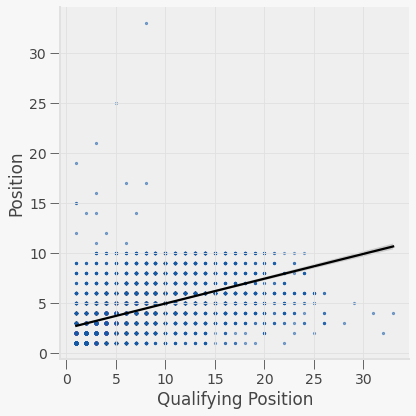

In [174]:
from sklearn import linear_model
no_zero = df_res_new[df_res_new['Qualifying Position'] > 0]

earned_points = no_zero[no_zero['Points']> 0]

X = earned_points.copy()
y = earned_points['Position']

# construct the model instance
simple_lr_model = linear_model.LinearRegression()

# fit the model
simple_lr_model.fit(X[["Qualifying Position"]], y)

# print the coefficients
beta_0 = simple_lr_model.intercept_
beta_1 = simple_lr_model.coef_[0]

print(f"Simple linear model: Position = {beta_0:.4f} + {beta_1:.4f} Qualifying Positiong")

sns.lmplot(
    data=earned_points, x="Qualifying Position", y="Position", height=6,
    scatter_kws=dict(s=5, alpha=0.5),
    line_kws={'color': 'black'}
);

immediately this makes much more sense, of course however our data is now limited in only the top 10 finishes and there is for sure still bias in this data.the bias that immediately comes to mind is that if we are only using points scorers in a race then we are using those with greater ability which means that there will of course be a stronger correlation to qualifying and race finish.

Now lets add more variables to this regression. For example it is known that in recent years certain tracks have been very difficult to overtake in. This is due to the cars being larger and the track width being very tight. The main one that has this issue is Monaco

In [143]:
monaco = order.loc[order['Name']== 'Monaco Grand Prix']



Abu Dhabi is one track known for a lot of overtakes so lets see if we get the same results

In [144]:
abu_dhabi = order.loc[order['Name']== 'Abu Dhabi Grand Prix']


based on a previous table we see that there are 79 tracks so let us run a regression for these 2 tracks that we have used but we can also take it a step further and use only points scorers


Simple linear model: Position = 2.2906 + 0.2753 Qualifying Positiong


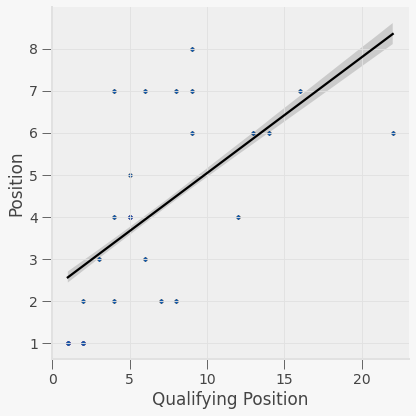

In [177]:
monaco_points = monaco.loc[monaco['Points']>0]

from sklearn import linear_model


X = monaco_points.copy()
y = monaco_points['Position']

# construct the model instance
simple_lr_model = linear_model.LinearRegression()

# fit the model
simple_lr_model.fit(X[["Qualifying Position"]], y)

# print the coefficients
beta_0 = simple_lr_model.intercept_
beta_1 = simple_lr_model.coef_[0]

print(f"Simple linear model: Position = {beta_0:.4f} + {beta_1:.4f} Qualifying Positiong")

sns.lmplot(
    data=monaco_points, x="Qualifying Position", y="Position", height=6,
    scatter_kws=dict(s=5, alpha=0.5),
    line_kws={'color': 'black'}
);

Simple linear model: Position = 5.3219 + 0.0925 Qualifying Positiong


,Race Id,Year,Circuit Id,Name,Results Id,Driver Id,Constructor ID,Car Number,Qualifying Position,Position,Points,Laps,milliseconds,Fastest Lap,Fastest Lap Position,fastestLapTime,fastestLapSpeed
34559,17,2009,24,Abu Dhabi Grand Prix,876,31,1,4,4,2,8.0,78,6237683,20,6,1:16.008,158.193
34558,17,2009,24,Abu Dhabi Grand Prix,857,8,1,3,9,5,4.0,66,5238634,40,5,1:17.357,215.328
34557,17,2009,24,Abu Dhabi Grand Prix,355,5,1,23,5,7,2.0,71,5706509,36,6,1:14.207,209.042
34569,17,2009,24,Abu Dhabi Grand Prix,1079,2,2,16,8,7,2.0,56,5944726,53,4,1:39.164,197.890
34568,17,2009,24,Abu Dhabi Grand Prix,1058,2,2,16,3,8,1.0,53,4537284,20,6,1:23.294,250.375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34749,1096,2022,24,Abu Dhabi Grand Prix,1035,23,7,7,15,7,2.0,58,5390419,58,8,1:29.084,215.715
34750,1096,2022,24,Abu Dhabi Grand Prix,1058,2,2,16,3,8,1.0,53,4537284,20,6,1:23.294,250.375
34751,1096,2022,24,Abu Dhabi Grand Prix,1079,2,2,16,8,7,2.0,56,5944726,53,4,1:39.164,197.890
34740,1096,2022,24,Abu Dhabi Grand Prix,857,8,1,3,9,5,4.0,66,5238634,40,5,1:17.357,215.328


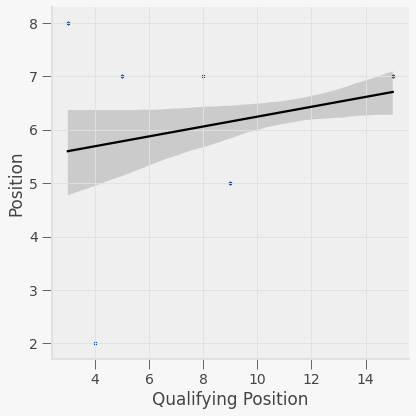

In [178]:
from sklearn import linear_model

abu_dhabi_points = abu_dhabi.loc[abu_dhabi['Points']>0]

X = abu_dhabi_points.copy()
y = abu_dhabi_points['Position']

# construct the model instance
simple_lr_model = linear_model.LinearRegression()

# fit the model
simple_lr_model.fit(X[["Qualifying Position"]], y)

# print the coefficients
beta_0 = simple_lr_model.intercept_
beta_1 = simple_lr_model.coef_[0]

print(f"Simple linear model: Position = {beta_0:.4f} + {beta_1:.4f} Qualifying Positiong")

sns.lmplot(
    data=abu_dhabi_points, x="Qualifying Position", y="Position", height=6,
    scatter_kws=dict(s=5, alpha=0.5),
    line_kws={'color': 'black'}
);
abu_dhabi_points

Monaco is a very historic track therefore we have. over 1700 observations of points scorers but for Abu Dhabi we only have a sample of 84. Therefore we can be sure that the Monaco regression shows us compared to the one ran earlier with just points scorers that on certain tracks like Monaco, where you start has more impact on where you end than other tracks, our intercept is lower and our beta1 is higher so you are less likely to gain track position.

Even though our sample for Abu Dhabi is small, it still does show us the extent to which overtaking is possible on these wider tracks, as the intercept is much larger and beta1 is much lower

## Lasso

To run this, I must hold one track constant as of course different tracks take a different amount of time to complete a lap, and additionally total race distance differs slightly between tracks. I will choose Monaco again for this lasso


In [147]:
# delete all non-numeric times
m1 = monaco[pd.to_numeric(monaco['milliseconds'], errors='coerce').notnull()]
m1['milliseconds'] = m1['milliseconds'].astype(int)
m1['Laptime (seconds)'] = m1['milliseconds']/ m1['Laps']
m1['Laptime (seconds)'] = m1['Laptime (seconds)']/1000
df = m1.drop(['Race Id','Driver Id', 'Car Number', 'Points','Name','Laps','Fastest Lap', 'Fastest Lap Position', 'Constructor ID', 'Results Id','Circuit Id',
             'fastestLapSpeed'], axis = 1)

df



/tmp/ipykernel_580/4026905282.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_580/4026905282.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_580/4026905282.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Year,Qualifying Position,Position,milliseconds,fastestLapTime,Laptime (seconds)
8811,1950,1,1,5675199,1:12.719,77.742452
8765,1950,17,10,5261939,1:30.918,99.281868
8766,1950,9,6,7047405,1:47.306,115.531230
8769,1950,16,14,5609825,1:37.680,100.175446
8771,1950,22,6,5195575,1:27.044,89.578879
...,...,...,...,...,...,...
9504,2022,8,2,5800722,1:17.430,82.867457
9508,2022,9,8,5514173,1:16.772,82.301090
9509,2022,6,3,5863923,1:21.195,83.770329
9510,2022,1,1,5732339,1:38.708,100.567351


In [148]:
df

,Year,Qualifying Position,Position,milliseconds,fastestLapTime,Laptime (seconds)
8811,1950,1,1,5675199,1:12.719,77.742452
8765,1950,17,10,5261939,1:30.918,99.281868
8766,1950,9,6,7047405,1:47.306,115.531230
8769,1950,16,14,5609825,1:37.680,100.175446
8771,1950,22,6,5195575,1:27.044,89.578879
...,...,...,...,...,...,...
9504,2022,8,2,5800722,1:17.430,82.867457
9508,2022,9,8,5514173,1:16.772,82.301090
9509,2022,6,3,5863923,1:21.195,83.770329
9510,2022,1,1,5732339,1:38.708,100.567351


We must split the data by eras - otherwise we will run into an issue where slower cars from the older eras will affect the regression. If we want to do it by time
the eras include: 1946-1950, 1950-1957, 1958- 1961, 1962- 1967, 1968-1976, 1977-1982, 1983-1988, 1989-1993, 1994, 1995-1999, 2000-2005, 2006-2008,, 2009-2013, 2014-2022.

This is a lot of eras - each era introduces new technical regulations that teams must abide by. of course there is a big difference from 2022 compared to 1950, but in order to make sure the sample size is not small I will divide it into ~ 20 year samples with the last one being 11 years.

But first in order to confirm this suspicion I will compare the average lap times at circuits over time to help visualize why I am splitting up the eras

In [175]:
order # I now need to create a visualization based on 'fastest lap speed'

,Race Id,Year,Circuit Id,Name,Results Id,Driver Id,Constructor ID,Car Number,Qualifying Position,Position,Points,Laps,milliseconds,Fastest Lap,Fastest Lap Position,fastestLapTime,fastestLapSpeed
8811,834,1950,6,Monaco Grand Prix,941,30,6,5,1,1,10.0,73,5675199,56,1,1:12.719,207.527
29847,839,1950,14,Italian Grand Prix,171,22,11,17,16,3,6.0,60,6031713,21,11,1:33.386,198.183
29848,839,1950,14,Italian Grand Prix,187,20,5,15,8,19,0.0,0,\N,\N,\N,\N,\N
29849,839,1950,14,Italian Grand Prix,204,21,10,21,20,16,0.0,67,5564967,67,20,1:18.208,210.546
29850,839,1950,14,Italian Grand Prix,219,14,9,9,13,11,0.0,70,5917474,67,16,1:22.732,190.634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14962,1083,2022,9,British Grand Prix,833,13,6,6,3,3,6.0,60,5763212,19,5,1:33.099,199.065
14963,1083,2022,9,British Grand Prix,848,18,11,12,6,18,0.0,28,\N,9,13,1:34.042,197.069
14964,1083,2022,9,British Grand Prix,867,24,5,20,15,15,0.0,63,\N,52,14,1:18.488,212.226
14956,1083,2022,9,British Grand Prix,789,23,7,7,6,3,6.0,57,5692670,45,10,1:27.810,217.410


/opt/conda/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:xlabel='Year', ylabel='fastestLapSpeed'>

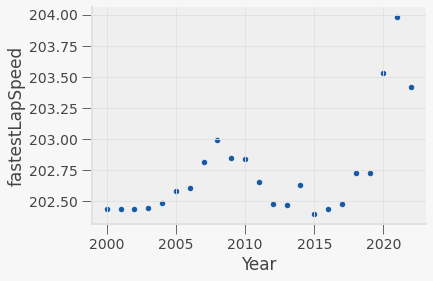

In [176]:
order = order[pd.to_numeric(order['fastestLapSpeed'], errors='coerce').notnull()]
order.fastestLapSpeed = order.fastestLapSpeed.astype(float)

res1 = order[order['Year']>= 2000]
res1 = res1.groupby(['Year'])['fastestLapSpeed'].mean().reset_index()
res1.plot.scatter(x = 'Year', y = 'fastestLapSpeed')

# also draw another graph of the average speed per track to highlight why we stick with only one track

<AxesSubplot:xlabel='Circuit Id', ylabel='fastestLapSpeed'>

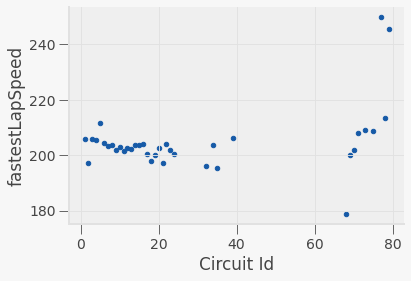

In [151]:
res2 = order[order['Year']>= 2000]
res2 = res2.groupby(['Circuit Id'])['fastestLapSpeed'].mean().reset_index()
res2.plot.scatter(x = 'Circuit Id', y = 'fastestLapSpeed')

I have used data from 2000 onwards as the older data for Lap Speed does not seem to be the most accurate as the cars appear much faster than what they seem from my research, none the less this still allows us to use over 20 years of data and as we can see from the graphs above that due to changes in regulation there are different speeds across different years and every track also has different average speeds therefore it makes sense to pick just one track when running the lasso to avoid this issue. I will pick Monaco as it is probably the most famous F1 track and it has a lot of data due to it's strong history.

In [152]:
df_era1 = df.loc[df['Year'].between(2000, 2005)]

In [153]:
df_era2 = df.loc[df['Year'].between(2006, 2011)]

In [154]:
df_era3 = df.loc[df['Year'].between(2012, 2016)]

In [155]:
df_era4 = df.loc[df['Year'].between(2017, 2022)]

In [156]:
df_era4

,Year,Qualifying Position,Position,milliseconds,fastestLapTime,Laptime (seconds)
9226,2017,2,1,5478555,1:35.405,97.831339
9230,2017,6,7,5273680,1:27.630,90.925517
9231,2017,14,6,7271150,1:19.574,95.673026
9232,2017,8,2,5800722,1:17.430,82.867457
9236,2017,9,8,5514173,1:16.772,82.301090
...,...,...,...,...,...,...
9504,2022,8,2,5800722,1:17.430,82.867457
9508,2022,9,8,5514173,1:16.772,82.301090
9509,2022,6,3,5863923,1:21.195,83.770329
9510,2022,1,1,5732339,1:38.708,100.567351


## First Era

In [157]:


X = df_era1.drop(['fastestLapTime'], axis=1).copy()
y = df_era1['Position']

mlr = linear_model.LinearRegression()
mlr.fit(X, y)


lasso = linear_model.Lasso(alpha = 0.01)
lasso.fit(X, y)

lasso_coefs = pd.Series(dict(zip(list(X), lasso.coef_)))
mlr_coefs = pd.Series(dict(zip(list(X), mlr.coef_)))
coefs = pd.DataFrame(dict(lasso=lasso_coefs, linreg=mlr_coefs))
coefs



,lasso,linreg
Year,0.000000e+00,1.971298e-16
Qualifying Position,1.439090e-04,5.329071e-15
Position,9.989427e-01,1.000000e+00
milliseconds,2.296702e-10,-1.602464e-16
Laptime (seconds),-0.000000e+00,-4.440698e-16


In [158]:

# lasso regression
mse_lasso = metrics.mean_squared_error(y, lasso.predict(X))
print('mse for lasso regression is', mse_lasso)

# linear regression
mse_linear = metrics.mean_squared_error(y, mlr.predict(X))
print('mse for linear regression is', mse_linear)

mse for lasso regression is 9.292562690041683e-06
mse for linear regression is 9.395061197799638e-21


In [159]:
X1_train, X1_test, y1_train, y1_test = model_selection.train_test_split(X, y, test_size=0.2)

mlr.fit(X1_train, y1_train)
print('linear MSE train:', metrics.mean_squared_error(y1_train, mlr.predict(X1_train)), ', '
    'MSE test:', metrics.mean_squared_error(y1_test, mlr.predict(X1_test)))
lasso.fit(X1_train, y1_train)
print('lasso MSE train:', metrics.mean_squared_error(y1_train, lasso.predict(X1_train)), ', '
    'MSE test:', metrics.mean_squared_error(y1_test, lasso.predict(X1_test)))

linear MSE train: 2.71685256454152e-29 , MSE test: 1.308311724507169e-29
lasso MSE train: 8.887501568238372e-06 , MSE test: 7.729380149605235e-06


# Second Era

In [160]:

X1 = df_era2.drop(['fastestLapTime'], axis=1).copy()
y1 = df_era2['Position']

lasso_coefs1 = pd.Series(dict(zip(list(X1), lasso.coef_)))
mlr_coefs1 = pd.Series(dict(zip(list(X1), mlr.coef_)))
coefs1 = pd.DataFrame(dict(lasso=lasso_coefs1, linreg=mlr_coefs1))
coefs1


,lasso,linreg
Year,0.000000e+00,2.088465e-17
Qualifying Position,9.023969e-05,8.486228e-16
Position,9.990260e-01,1.000000e+00
milliseconds,9.947301e-11,-5.082198e-21
Laptime (seconds),0.000000e+00,-2.160214e-16


In [161]:
# lasso regression
mse_lasso1 = metrics.mean_squared_error(y1, lasso.predict(X1))
print('mse for lasso regression is', mse_lasso1)

# linear regression
mse_linear1 = metrics.mean_squared_error(y1, mlr.predict(X1))
print('mse for linear regression is', mse_linear1)

mse for lasso regression is 8.65454611046734e-06
mse for linear regression is 2.3951307530915618e-29


In [162]:
X2_train, X2_test, y2_train, y2_test = model_selection.train_test_split(X1, y1, test_size=0.2)

mlr.fit(X2_train, y2_train)
print('linear MSE train:', metrics.mean_squared_error(y2_train, mlr.predict(X2_train)), ', '
    'MSE test:', metrics.mean_squared_error(y2_test, mlr.predict(X2_test)))
lasso.fit(X2_train, y2_train)
print('lasso MSE train:', metrics.mean_squared_error(y2_train, lasso.predict(X2_train)), ', '
    'MSE test:', metrics.mean_squared_error(y2_test, lasso.predict(X2_test)))

linear MSE train: 5.083186987653451e-29 , MSE test: 6.066058625112002e-29
lasso MSE train: 9.879048753061656e-06 , MSE test: 1.3612543619645623e-05


# Third Era

In [163]:
X2 = df_era3.drop(['fastestLapTime'], axis=1).copy()
y2 = df_era3['Position']

mlr.fit(X2, y2)

lasso.fit(X2, y2)

lasso_coefs2 = pd.Series(dict(zip(list(X2), lasso.coef_)))
mlr_coefs2 = pd.Series(dict(zip(list(X2), mlr.coef_)))
coefs2 = pd.DataFrame(dict(lasso=lasso_coefs2, linreg=mlr_coefs2))
coefs2

,lasso,linreg
Year,0.000000e+00,0.000000e+00
Qualifying Position,1.439090e-04,3.412899e-16
Position,9.989427e-01,1.000000e+00
milliseconds,2.296702e-10,-2.449183e-16
Laptime (seconds),-0.000000e+00,2.775558e-16


In [164]:
# lasso regression
mse_lasso2 = metrics.mean_squared_error(y2, lasso.predict(X2))
print('mse for lasso regression is', mse_lasso2)

# linear regression
mse_linear2 = metrics.mean_squared_error(y2, mlr.predict(X2))
print('mse for linear regression is', mse_linear2)

mse for lasso regression is 9.292562690036335e-06
mse for linear regression is 2.1948866390192035e-20


In [165]:
X3_train, X3_test, y3_train, y3_test = model_selection.train_test_split(X2, y2, test_size=0.2)

mlr.fit(X3_train, y3_train)
print('linear MSE train:', metrics.mean_squared_error(y3_train, mlr.predict(X3_train)), ', '
    'MSE test:', metrics.mean_squared_error(y3_test, mlr.predict(X3_test)))
lasso_model.fit(X3_train, y3_train)
print('lasso MSE train:', metrics.mean_squared_error(y3_train, lasso.predict(X3_train)), ', '
    'MSE test:', metrics.mean_squared_error(y3_test, lasso.predict(X3_test)))

linear MSE train: 5.310731898234585e-29 , MSE test: 5.212432433873061e-29
lasso MSE train: 8.313340615295241e-06 , MSE test: 1.320945098900073e-05


# Fourth Era

In [166]:
X3 = df_era4.drop(['fastestLapTime'], axis=1).copy()
y3 = df_era4['Position']

mlr.fit(X3, y3)

lasso.fit(X3, y3)

lasso_coefs3 = pd.Series(dict(zip(list(X3), lasso.coef_)))
mlr_coefs3 = pd.Series(dict(zip(list(X3), mlr.coef_)))
coefs3 = pd.DataFrame(dict(lasso=lasso_coefs3, linreg=mlr_coefs3))
coefs3

,lasso,linreg
Year,0.000000e+00,0.000000e+00
Qualifying Position,1.439090e-04,4.149045e-15
Position,9.989427e-01,1.000000e+00
milliseconds,2.296702e-10,4.832814e-16
Laptime (seconds),-0.000000e+00,-8.100263e-16


In [167]:
# lasso regression
mse_lasso3 = metrics.mean_squared_error(y3, lasso.predict(X3))
print('mse for lasso regression is', mse_lasso3)

# linear regression
mse_linear3 = metrics.mean_squared_error(y3, mlr.predict(X3))
print('mse for linear regression is', mse_linear3)

mse for lasso regression is 9.292562690036835e-06
mse for linear regression is 8.546431623839799e-20


In [168]:
X4_train, X4_test, y4_train, y4_test = model_selection.train_test_split(X3, y3, test_size=0.2)

mlr.fit(X4_train, y4_train)
print('linear MSE train:', metrics.mean_squared_error(y4_train, mlr.predict(X4_train)), ', '
    'MSE test:', metrics.mean_squared_error(y4_test, mlr.predict(X4_test)))
lasso_model.fit(X4_train, y4_train)
print('lasso MSE train:', metrics.mean_squared_error(y4_train, lasso.predict(X4_train)), ', '
    'MSE test:', metrics.mean_squared_error(y4_test, lasso.predict(X4_test)))

linear MSE train: 2.1135606807071796e-29 , MSE test: 1.7669464198193912e-29
lasso MSE train: 9.965510317113523e-06 , MSE test: 6.60077218173009e-06


For all eras the MSE is larger in the lasso tests so it is a better measurement for the data.

# Conclusion

1. This Project was very fun to work on but the more I worked on it, it quickly became apparent that for the analysis I was doing I must increase the scope of the project by quite a lot to get accurate predictors - This includes making a dummy variable for each and every track when running regressions as well as things like taking into account which team has the fastest car.
2. Even though my analysis may be limited there were some interesting takeaways, Qualifying position does in fact to be the number one contributor to where a driver will finish on race day, but it would be interesting to expand on this project one day to the determinants of qualifying position.
3. Multi-collinearity exists within the variables so it is hard to find the true effect of a single variable

# References

These two projects helped me with some of the coding my visualizations and bettered my understand of lasso

https://notes.quantecon.org/submission/5cdb1a58b955b800107296cc

https://nbviewer.org/github/silaslm/NBA-Player-Salary-Determinants/blob/main/NBA_Player_Salary_Determinants-2.ipynb
